In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from torchvision import transforms,  models
import tqdm as tqdm
import matplotlib.pyplot as plt
import cv2
from datetime import datetime
from pathlib import Path
import os
import torch.utils.data
import torch
import numpy as np
import torchvision
import shutil
from tqdm import tqdm
import copy
import sys

In [ ]:
data_root = 'drive/My Drive/datasets/'
train_dir = 'train'
val_dir = 'val'
class_names = ['combined','dry','fat','normal']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 3 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 66/66 [00:00<00:00, 369.44it/s]


In [ ]:
from torchvision import transforms
train_dir = 'train'
val_dir = 'val'
train_transforms1 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

])
train_transforms2 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
train_transforms3 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
train_transforms4 = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
train_transforms5 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])


# print(type(train_transforms))
train_dataset1 = torchvision.datasets.ImageFolder(train_dir, train_transforms1)
train_dataset2 = torchvision.datasets.ImageFolder(train_dir, train_transforms2)
train_dataset3 = torchvision.datasets.ImageFolder(train_dir, train_transforms3)
train_dataset4 = torchvision.datasets.ImageFolder(train_dir, train_transforms4)
train_dataset5 = torchvision.datasets.ImageFolder(train_dir, train_transforms5)
train_dataset = train_dataset2+train_dataset3+train_dataset1+train_dataset4+train_dataset5
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 5
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

FileNotFoundError: ignored

In [ ]:
len(train_dataset),len(val_dataset),len(train_dataloader),len(val_dataloader)

(1145, 127, 229, 26)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
los_val = []
ac_val = []
los_train = []
ac_train = []
epoches_val = []
epoches_train = []
data_labels_train = []
preds_train = []


def train_model(model, loss, optimizer, num_epochs):
    best_acc = 0
    # best_model_wts = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  
            else:
                dataloader = val_dataloader
                model.eval()  

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

  
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        data_labels_train.append(labels.data)
                        preds_train.append(preds_class)

                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            if phase == 'val':
                ac_val.append(float(epoch_acc))
                los_val.append(float(epoch_loss))
                epoches_val.append(epoch)
            elif phase == 'train':
                ac_train.append(float(epoch_acc))
                los_train.append(float(epoch_loss))
                epoches_train.append(epoch)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

            if phase == 'val' and (epoch_acc > best_acc) and (epoch_loss < 0.45):
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
            

    # print(sorted(los))
    model.load_state_dict(best_model_wts)   
    return model

In [ ]:
model = models.densenet121(pretrained=True)
#
# for param in model.parameters():
#     param.requires_grad = False

model.classifier= torch.nn.Linear(model.classifier.in_features, 4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

train_model(model = model,loss=loss,optimizer= optimizer, num_epochs= 70)


model_dir = 'drive/My Drive/networks/'
torch.save(model, os.path.join(model_dir,'model_denseten121.pth'))

orig_stdout = sys.stdout
with open(os.path.join(model_dir,'model_denseten121.txt'),'w') as f:
  sys.stdout = f
  f.write(str(model))
  f.close()
sys.stdout = orig_stdout


In [ ]:

epoches_val.append('epoches')
epoches_train.append('epoches')
los_val.append('loss')
los_train.append('loss')
ac_val.append('accur')
ac_train.append('accur')
from google.colab import files
with open('params_densenet121_100_train_colab.txt','w') as file:
    file.write(str(epoches_train) + '\n')
    file.write(str(los_train) + '\n')
    file.write(str(ac_train))
    file.close()
files.download('params_densenet121_100_train_colab.txt')
with open('params_densenet121_100_val_colab.txt', 'w') as file:
    file.write(str(epoches_val) + '\n')
    file.write(str(los_val) + '\n')
    file.write(str(ac_val))
    file.close()
files.download('params_densenet121_100_val_colab.txt')

ТЕСТИРОВАНИЕ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from torchvision import transforms,  models
import tqdm as tqdm
import matplotlib.pyplot as plt
import cv2
from datetime import datetime
from pathlib import Path
import os
import torch.utils.data
import torch
import numpy as np
import torchvision
import shutil
from tqdm import tqdm
import copy
import sys

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_dir = 'drive/My Drive/networks/'
model = torch.load(os.path.join(model_dir,'model_denseten121.pth'))
model.eval()


model=model.to(torch.device("cpu"))
#model_ft=torch.quantization.convert(model_ft)
#torch.jit.script(model_ft).save("/content/drive/My Drive/AI/Samsung/fire_net.pt")
input_tensor = torch.rand(1,3,224,224)
script_model = torch.jit.trace(model,input_tensor)
script_model.save("drive/My Drive/networks/model_densenet121.pt")



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [ ]:
params = list(model.parameters())
q_param = 0

for i in range(len(params)):
  q_param += len(params[i])
  # print(len(params[i]))
print(q_param)
print(len(params))

93896
364


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


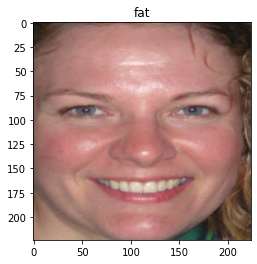

In [ ]:
data_root = 'drive/My Drive/datasets/'
test_dir = 'test'

shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))
prediction = []

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def show_input(input_tensor, title=''):
    image = input_tensor.cpu().permute(1,2,0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)


test_dataset = torchvision.datasets.ImageFolder(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=1)

model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy())



test_predictions = np.concatenate(test_predictions)
 
for i in range(len(test_predictions[0])):
  prediction.append(test_predictions[0][i])
for img, pred in zip(inputs, prediction):
    if max(prediction) == prediction[0]:
        pred = 'combined'
    elif max(prediction) == prediction[1]:
        pred = 'dry'
    elif max(prediction) == prediction[2]:
        pred = 'fat'
    elif max(prediction) == prediction[3]:
        pred = 'normal'
   
show_input(img, title=pred)

